# Chapter 8 - Dimensionality Reduction Code Reproduction

In [1]:
# Impor umum
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

# Konfigurasi plot
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Membuat dataset 3D sederhana
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# 1. Pusatkan data (center the data)
X_centered = X - X.mean(axis=0)

# 2. Gunakan SVD untuk mendapatkan principal components
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

# 3. Proyeksikan data ke bidang 2D
W2 = Vt.T[:, :2]
X2D_svd = X_centered.dot(W2)

In [3]:
from sklearn.decomposition import PCA

# Inisialisasi PCA untuk mereduksi menjadi 2 dimensi
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# Principal components (vektor-vektornya)
print("Principal Components (dari Scikit-Learn):\n", pca.components_.T)

# Explained variance ratio
print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)
# HASIL: Menunjukkan persentase varians yang ditangkap oleh setiap komponen.

Principal Components (dari Scikit-Learn):
 [[ 0.93636116 -0.34027485]
 [ 0.29854881  0.90119108]
 [ 0.18465208  0.2684542 ]]

Explained Variance Ratio: [0.84248607 0.14631839]


In [4]:
from sklearn.datasets import fetch_openml

# Memuat dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist["data"]
y_mnist = mnist["target"]

# Menjalankan PCA tanpa reduksi untuk mendapatkan semua explained variance
pca_full = PCA()
pca_full.fit(X_mnist)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Menemukan jumlah dimensi yang dibutuhkan untuk 95% varians
d = np.argmax(cumsum >= 0.95) + 1
print("\nJumlah dimensi untuk 95% varians:", d)

# Menjalankan PCA sekali lagi dengan jumlah dimensi yang tepat
pca_95 = PCA(n_components=0.95)
X_reduced = pca_95.fit_transform(X_mnist)
print("Bentuk data setelah reduksi:", X_reduced.shape)


Jumlah dimensi untuk 95% varians: 154
Bentuk data setelah reduksi: (70000, 154)


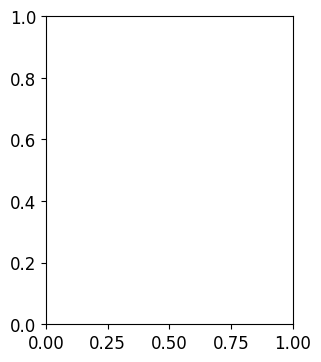

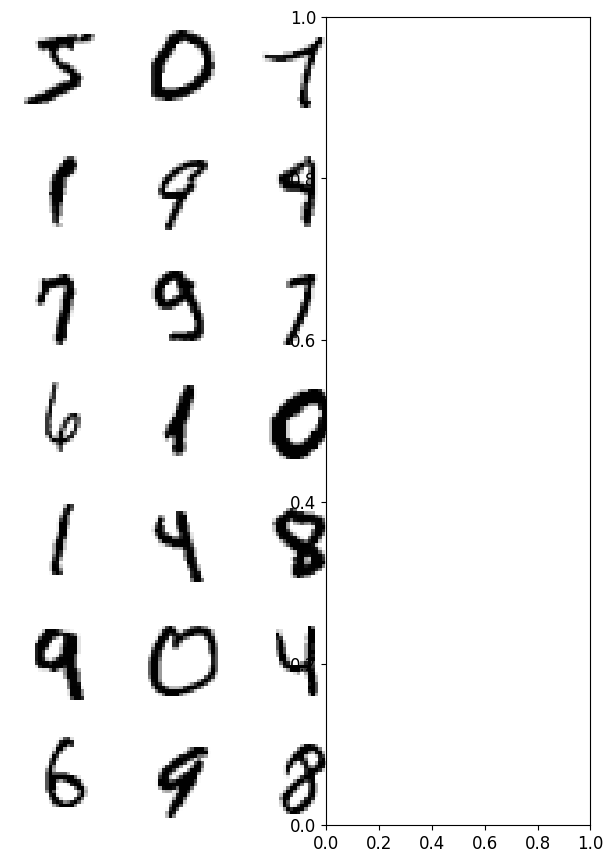

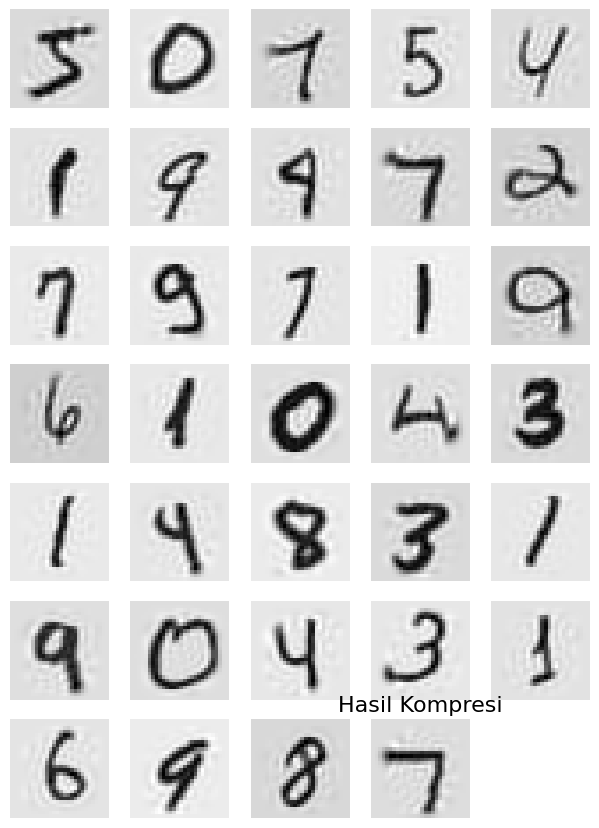

In [5]:
# Gunakan PCA yang sudah dilatih dengan n_components=154 (hasil dari atas)
pca_compress = PCA(n_components=154)
X_mnist_reduced = pca_compress.fit_transform(X_mnist)
X_mnist_recovered = pca_compress.inverse_transform(X_mnist_reduced)

# Fungsi untuk plot
def plot_digits(instances, images_per_row=5, **options):
    # ... (fungsi plot dari buku, disederhanakan di sini)
    n_images = len(instances)
    n_rows = (n_images - 1) // images_per_row + 1
    plt.figure(figsize=(images_per_row * 1.5, n_rows * 1.5))
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(instances[i].reshape(28, 28), cmap="binary", **options)
        plt.axis("off")

# Plot gambar asli dan hasil rekonstruksi
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Asli", fontsize=16)
plt.subplot(122)
plot_digits(X_mnist_recovered[::2100])
plt.title("Hasil Kompresi", fontsize=16)
plt.show()
# HASIL: Gambar hasil rekonstruksi sedikit kabur (lossy compression) tapi masih dapat dikenali.

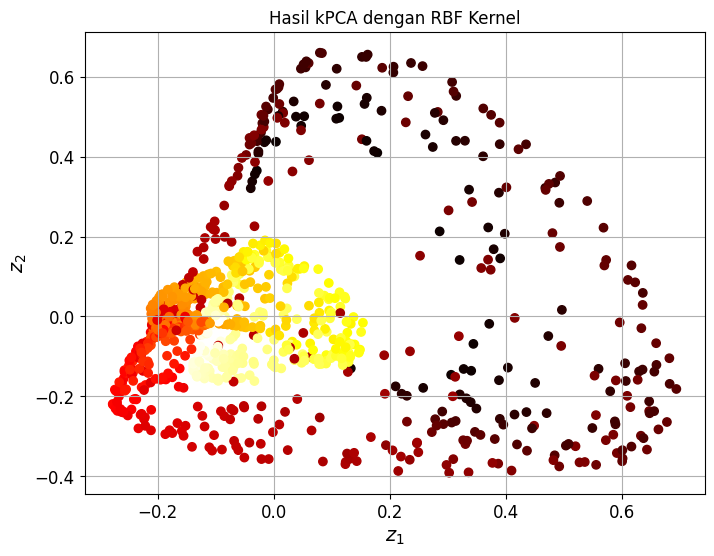

In [6]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

# Membuat dataset Swiss roll
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Menggunakan Kernel PCA dengan kernel RBF
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_kpca = rbf_pca.fit_transform(X_swiss)

# Plot hasil kPCA
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=t, cmap=plt.cm.hot)
plt.title("Hasil kPCA dengan RBF Kernel")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()
# HASIL: Manifold Swiss roll berhasil "dibuka" menjadi bidang 2D yang terpisah dengan baik.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Membuat pipeline: kPCA diikuti oleh Logistic Regression
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

# Menyiapkan parameter grid untuk dicari
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

# Melakukan grid search
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_swiss, t > 6.9) # t > 6.9 untuk membuat target klasifikasi biner

print("\nParameter terbaik (kPCA):", grid_search.best_params_)


Parameter terbaik (kPCA): {'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}


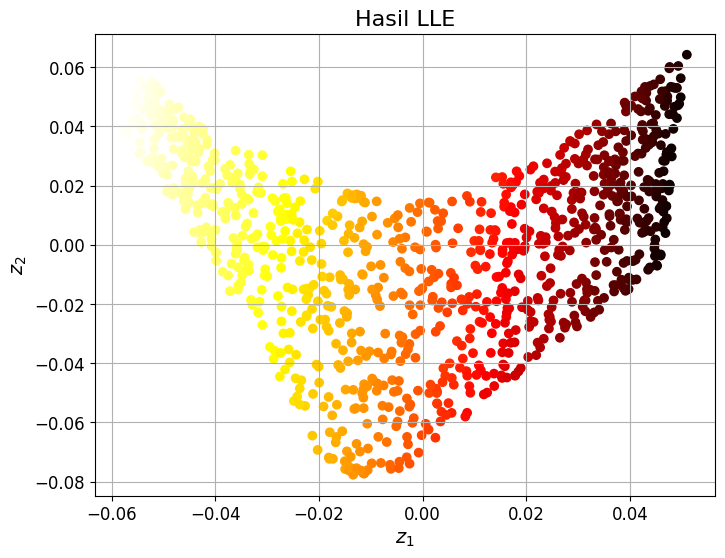

In [8]:
from sklearn.manifold import LocallyLinearEmbedding

# Menggunakan LLE untuk mereduksi dimensi
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

# Plot hasil LLE
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.title("Hasil LLE", fontsize=16)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()